# User Analysis

We need to evaluate if artists in the dataset are used by many users.

If an Artist's occurences all stem from one or a few users it is not a general behaviour.



In [2]:
import pandas as pd
df_large = pd.read_parquet('../sources/metadata-large.parquet', engine='pyarrow')

exact_matches = pd.read_parquet("../results/artists_exact_match_large.parquet", engine='pyarrow')
assert "artists" in exact_matches.columns, f'artists is not in {exact_matches.columns}'
assert "num_artists" in exact_matches.columns, f'num_artists is not in {exact_matches.columns}'

import my_utils

artist_mentions = pd.read_parquet('../results/artist_mentions.parquet', engine='pyarrow')

In [3]:
print(df_large.columns)

print(f'number of unique users for all prompts {df_large.user_name.unique().shape}')

df_large = df_large.drop_duplicates(subset="prompt").copy()

print(f'number of unique users for unique prompts {df_large.user_name.unique().shape}')

Index(['image_name', 'prompt', 'part_id', 'seed', 'step', 'cfg', 'sampler',
       'width', 'height', 'user_name', 'timestamp', 'image_nsfw',
       'prompt_nsfw'],
      dtype='object')
number of unique users for all prompts (10381,)
number of unique users for unique prompts (10351,)


## User Counts

In [4]:
print(f'df_large amount of entries {df_large.shape[0]}')

counts = df_large.groupby(['user_name'])['user_name'].count().reset_index(name="prompt_count")
print(counts.head())
print('prompt_count described:')
print(counts.prompt_count.describe())

df_large amount of entries 1819808
                                           user_name  prompt_count
0  0007a89ce78510288e26962da31b4f1fa25be114d3d613...             4
1  000b817b146b34f4056cf326c6899343a94230c19b1f64...            93
2  0012d3eb8d1362994412a18cb8e429e945395490d297aa...           181
3  00234b9dc16609c19e09d6cbf255054583b3bdd7933233...           120
4  003a22f98856c3eeb5b805cd42f96d57dd09a5334fbec8...            11
prompt_count described:
count    10351.000000
mean       175.809873
std        346.720842
min          1.000000
25%         12.000000
50%         56.000000
75%        196.000000
max      14059.000000
Name: prompt_count, dtype: float64


   prompt_count  user_count
0             1         442
1             2         351
2             3         307
3             4         267
4             5         230
5             6         165
6             7         171
7             8         154
8             9         156
9            10         110
count    1080.000000
mean        9.584259
std        27.725891
min         1.000000
25%         1.000000
50%         2.000000
75%         7.000000
max       442.000000
Name: user_count, dtype: float64


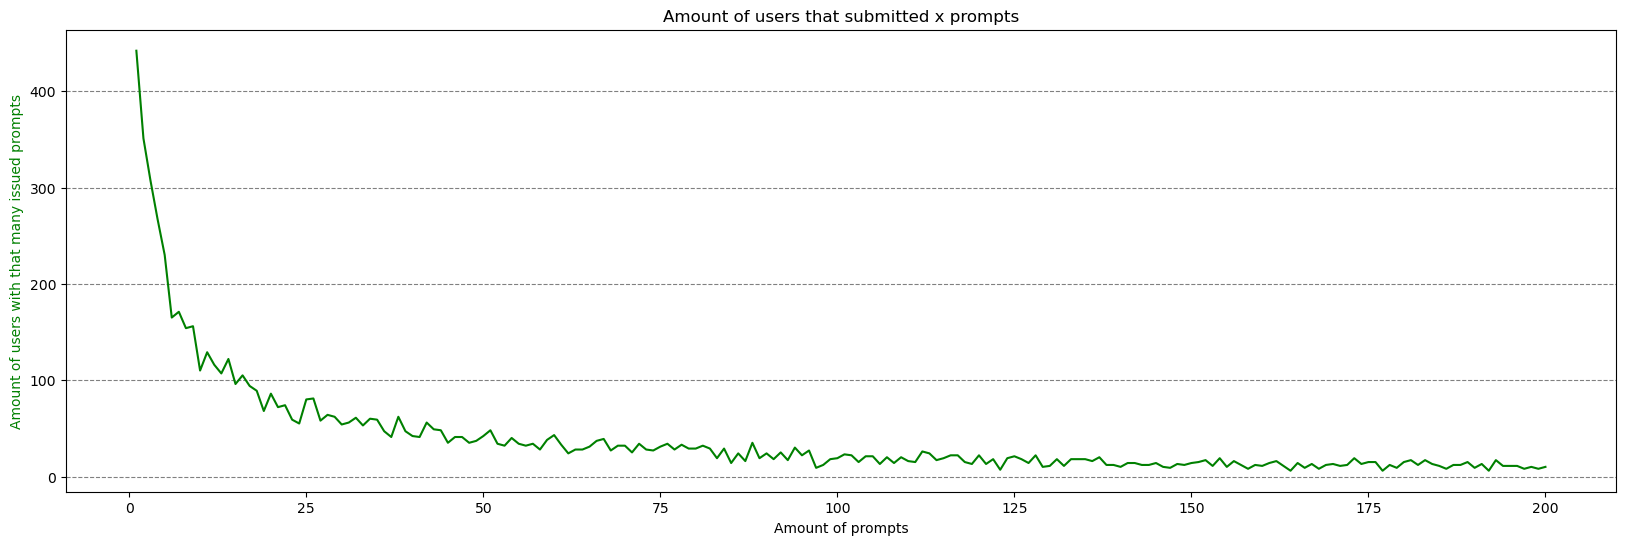

In [26]:
# amount of users with x prompts

counts_count = counts.groupby(['prompt_count'])['prompt_count'].count().reset_index(name="user_count")
print(counts_count.head(10))
print(counts_count.user_count.describe())

import matplotlib.pyplot as plt
x_data = []
y_data_amount_of_users = []

top = 200
i = 0
for index, series in counts_count.iterrows():
    if i==top:
        break
    else:
        i=i+1
    x_data.append(series.prompt_count)
    y_data_amount_of_users.append(series.user_count)

fig, ax = plt.subplots(figsize=(20,6))
ax.set_axisbelow(True)
ax.yaxis.grid(color='gray', linestyle='dashed')
ax.plot(x_data, y_data_amount_of_users, 'g-')

ax.set_xlabel('Amount of prompts')
ax.set_ylabel('Amount of users with that many issued prompts', color='g')
ax.set_title('Amount of users that submitted x prompts')


plt.savefig('user_amounts.png')
plt.show()

# Top Users

In [29]:
percent = 50

counts_count['sum'] = counts_count['prompt_count'] * counts_count['user_count']
print(counts_count.head())


total = counts_count['sum'].sum()
print(f'total {total} prompts')
sorted = counts_count.sort_values("sum" , ascending=False)
print(sorted.head(20))
counter=0
sum = 0
for index, series in sorted.iterrows():
    sum = sum + series['sum']
    counter = counter + series["user_count"]
    if sum > (total / 100 * percent):
        break

print(f'The {counter} ({counter / counts.shape[0] * 100})% most active users make up {percent}% of prompts')

   prompt_count  user_count   sum
0             1         442   442
1             2         351   702
2             3         307   921
3             4         267  1068
4             5         230  1150
total 1819808 prompts
      prompt_count  user_count    sum
1079         14059           1  14059
1078          7049           1   7049
1077          5311           1   5311
478            484          10   4840
1076          4737           1   4737
1075          4603           1   4603
1050          2149           2   4298
586            606           7   4242
563            578           7   4046
305            307          13   3991
840            997           4   3988
490            496           8   3968
628            657           6   3942
833            974           4   3896
1074          3889           1   3889
231            232          16   3712
363            365          10   3650
226            227          16   3632
1073          3581           1   3581
895           

## Artists related to users

In [2]:
# amount of mentions divided by unique users that mention the artist

artist_mentions.sort_values("mentions", axis=0, ascending=False, inplace=True)

def get_num_unique_users(artist_name):
    #print(artist_name)
    #print(type(artist_name))
    entries = my_utils.exact_match_dataframe(exact_matches, artist_name)
    return entries.user_name.unique().shape[0]
    

artist_mentions["num_unique_users"] = artist_mentions.artist.apply(lambda x: get_num_unique_users(x))
print(artist_mentions.head())

artist_mentions.sort_values("mentions", axis=0, ascending=False)
artist_mentions.to_csv("../results/artist_mentions_unique_users.csv", escapechar = "\\")
artist_mentions.to_parquet("../results/artist_mentions_unique_users.parquet")


                      artist  mentions  num_unique_users
1999          Greg Rutkowski    180080              3811
3294  Trending on artstation    170077              4617
99                   Artgerm    136220              3283
1648          Alphonse Mucha     81170              2864
3266                    WLOP     63075              2228


# Visualization

                      artist  mentions  num_unique_users  mentions_by_users
1999          Greg Rutkowski    180080              3811          47.252690
3294  Trending on artstation    170077              4617          36.837124
99                   Artgerm    136220              3283          41.492537
1648          Alphonse Mucha     81170              2864          28.341480
3266                    WLOP     63075              2228          28.310144


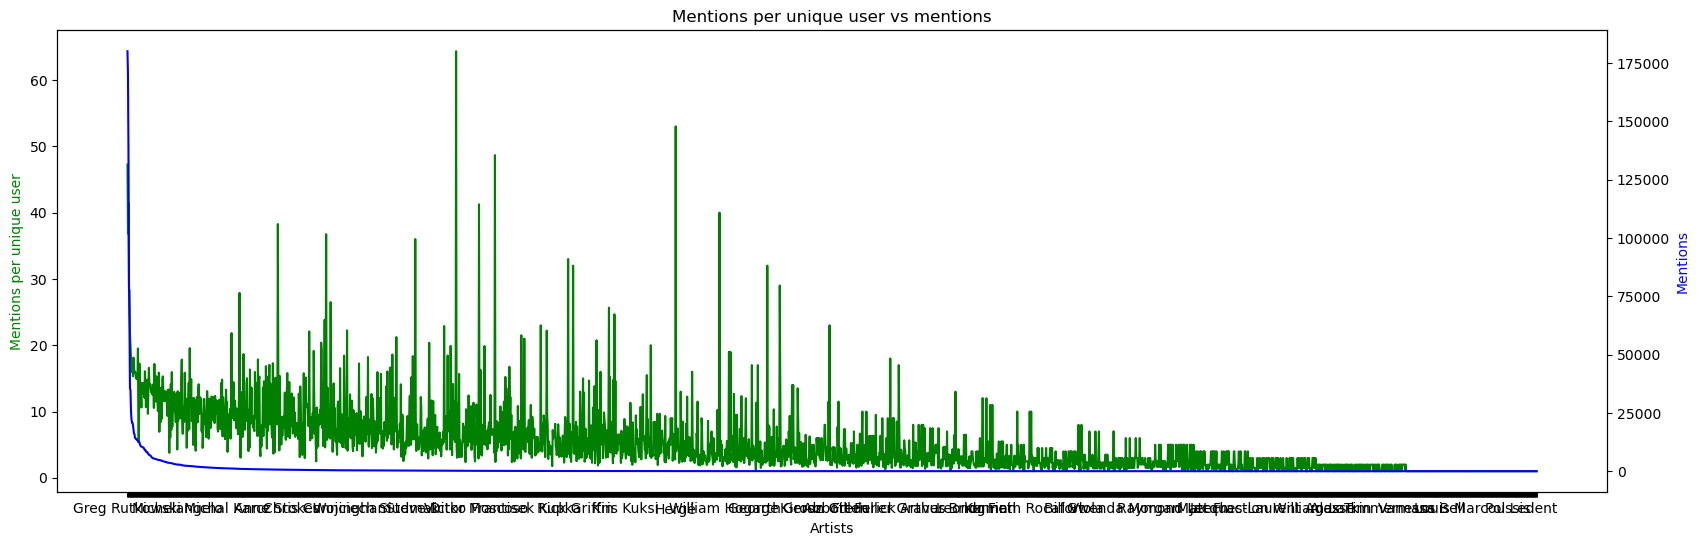

In [8]:
artist_mentions = pd.read_parquet('../results/artist_mentions_unique_users.parquet', engine='pyarrow')

assert "num_unique_users" in artist_mentions.columns

artist_mentions["mentions_by_users"] = artist_mentions.mentions / artist_mentions.num_unique_users

artist_mentions.sort_values("mentions", axis=0, ascending=False, inplace=True)
artist_mentions = artist_mentions[artist_mentions.mentions > 0]

print(artist_mentions.head())


import matplotlib.pyplot as plt
x_data = []
y_data_mentions_by_users = []
y_data_mentions = []

i = 0
for index, series in artist_mentions.iterrows():
    x_data.append(series.artist)
    y_data_mentions_by_users.append(series.mentions_by_users)
    y_data_mentions.append(series.mentions)


fig, ax1 = plt.subplots(figsize=(20,6))
ax2 = ax1.twinx()
ax1.plot(x_data, y_data_mentions_by_users, 'g-')
ax2.plot(x_data, y_data_mentions, 'b-')

every_nth = 100
for n, label in enumerate(ax1.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)

for n, label in enumerate(ax2.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)


ax1.set_xlabel('Artists')
ax1.set_ylabel('Mentions per unique user', color='g')
ax2.set_ylabel('Mentions', color='b')
ax1.set_title('Mentions per unique user vs mentions')
# a smaller amount of mentions per unique user means the artist is widely used

plt.show()

In [ ]:
mentions vs unique users